## Setting up

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import deconfuser.sample_planets as sample_planets
import deconfuser.orbit_fitting as orbit_fitting
import deconfuser.orbit_grouping as orbit_grouping
import deconfuser.partition_ranking as partition_ranking

## Observations
deconfuser.sample_planets can be used to simulate observations.
For illustration purposed, we use fixed data instead:

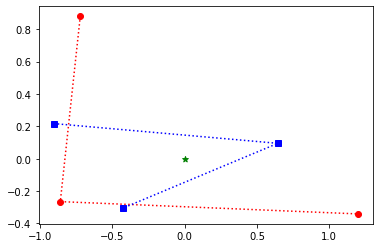

In [10]:
mu = 4*np.pi**2 #gravitational parameter of the 1 solar mass star in AU^3/year^2
ts = [0.0, 0.5, 1.0]# observation times in years

xys1 = np.array([[-0.721, 0.880], [-0.859, -0.265], [1.199, -0.341]])#planet 1 detections in AU
xys2 = np.array([[-0.904, 0.217], [0.644, 0.095], [-0.426, -0.305]])#planet 2 detections in AU

plt.plot(xys1[:,0], xys1[:,1], marker="o", color="r", linestyle=":")
plt.plot(xys2[:,0], xys2[:,1], marker="s", color="b", linestyle=":")
plt.scatter([0], [0], marker="*", color="green") #star

## Orbit fitting and multiple "perfect-fit" orbits
We want to find all orbits that fit the data with RMS < 0.05 AU with semi-major axes between 0.3 and 3 AU and eccentricity below 0.3.

There are two very distinct orbits that fit the detections of the second planet at the times given. These two orbits complete a different number of revolutions between first and third detections.

Semi-major axis 0.851, eccentricity 0.131
RMS fit error 0.0028

Semi-major axis 1.090, eccentricity 0.027
RMS fit error 0.0059



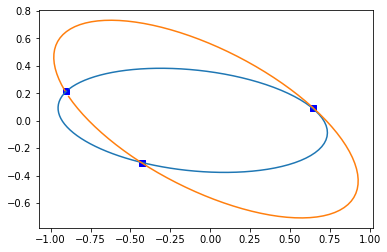

In [11]:
of = orbit_fitting.OrbitFitter(mu, ts, min_a=0.3, max_a=3, max_e=0.3, tol=0.05)

for err, (a, e, i, o, O, M0) in of.fit(xys2):
    print("Semi-major axis %.3f, eccentricity %.3f"%(a,e))
    print("RMS fit error %.4f"%(err))
    print()
    
    #plot trajectories:
    xs,ys = sample_planets.get_observations(a, e, i, o, O, M0, 2*np.pi*np.sqrt(a**3/mu)*np.arange(0,1,0.01), mu)
    plt.plot(xs[0], ys[0])
plt.scatter(xys2[:,0], xys2[:,1], marker="s", color="b")

## Orbits that fit detections of different planets

There are also orbits the perfectly fit detection of both planets. If we don't know ahead of time which detection belongs to which planet this might caused confusion. Below is an example of one such orbit.

Semi-major axis 0.846, eccentricity 0.168
RMS fit error 0.1213

Semi-major axis 1.153, eccentricity 0.123
RMS fit error 0.0079



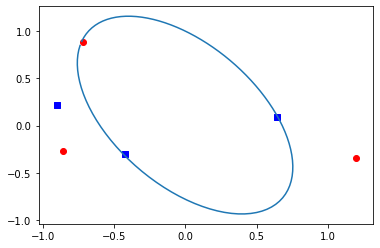

In [12]:
xys_wrong = np.array([xys1[0], xys2[1], xys2[2]])

for err, (a, e, i, o, O, M0) in of.fit(xys_wrong):
    print("Semi-major axis %.3f, eccentricity %.3f"%(a,e))
    print("RMS fit error %.4f"%(err))
    print()
    if err > 0.05: continue
        
    xs,ys = sample_planets.get_observations(a, e, i, o, O, M0, 2*np.pi*np.sqrt(a**3/mu)*np.arange(0,1,0.01), mu)
    plt.plot(xs[0], ys[0])
    
plt.scatter(xys1[:,0], xys1[:,1], marker="o", color="r")
plt.scatter(xys2[:,0], xys2[:,1], marker="s", color="b")

## Fitting all valid orbits
Given 2 detections at each of the 3 observation epochs, there are 2^3=8 possible orbits that fit all detections:
* (detection 1 @ epoch 1, detection 1 @ epoch 2, detection 1 @ epoch 3)
* (detection 2 @ epoch 1, detection 1 @ epoch 2, detection 1 @ epoch 3)
* ...

Even more orbits are possible if we assume there are more than two planets, not all detected at all times. Most of these orbits have an unrealistic eccentricity (e.g., not bound to the host star).

The OrbitGrouper class incrementally fits orbit, first 1 detection per planet, then 2, and so on. While doing so, it filters out groups of detections that cannot be fitted with an orbit within certain constraints.

In [13]:
xys = np.concatenate([xys1, xys2]) #pretend we dont know which detection corresponds to which planet
obs_ts = np.tile(ts, 2) #the times at which the planets were detected

#search for detectoin-to-planet groupings that can be fitted with an orbit within 0.05 AU RMS error.
#The orbits should have semi-major axes between 0.3 and 3 AU and eccentricities below 0.3.
og = orbit_grouping.OrbitGrouper(mu, ts, min_a=0.3, max_a=3, max_e=0.3, tol=0.05)
groups = og.group_orbits(xys, obs_ts)
print("The indices of the 6 detections can be fitted with a valid orbit:")
print(groups)

The indices of the 6 detections can be fitted with a valid orbit:
[(0,), (1,), (2,), (3,), (4,), (5,), (0, 1), (0, 2), (0, 4), (0, 5), (1, 2), (1, 3), (1, 5), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5), (0, 1, 2), (0, 4, 5), (1, 2, 3), (2, 3, 4), (3, 4, 5)]


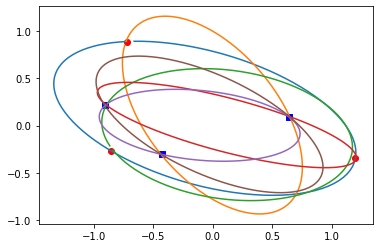

In [14]:
#plot all orbits with that match 3 detections
for g in groups:
    if len(g) < 3: continue
    for err, (a, e, i, o, O, M0) in of.fit(xys[g,:]):
        if err > 0.05: continue

        xs,ys = sample_planets.get_observations(a, e, i, o, O, M0, 2*np.pi*np.sqrt(a**3/mu)*np.arange(0,1,0.01), mu)
        plt.plot(xs[0], ys[0])

plt.scatter(xys1[:,0], xys1[:,1], marker="o", color="r")
plt.scatter(xys2[:,0], xys2[:,1], marker="s", color="b")

## Partitioning detections
While there are many ways to group detections by planet, some are mutually inconsistent. For example, the orbit that fits detections (0,1,2) is inconsistent with the orbit that fits detections (0,4,5). They share detection 0 which can only belong two one of the presumed planets.

To ensure consistency, we want to partition (split into disjoint groups) the detections by orbits. There are many possible partitions, some assuming more planets than others. The more planets are assumed, the less detections are grouped together for each planet, the less likely the partition becomes.

Below, we find and sort all partitions of the detections by planets, based on the "valid" orbits found above.

In [15]:
partitions = list(partition_ranking.get_ranked_partitions(groups))
for partition in partitions:
    print(partition)

[[0, 1, 2], [3, 4, 5]]
[[0, 4, 5], [1, 2, 3]]
[[2, 3, 4], [0, 1], [5]]
[[2, 3, 4], [0, 5], [1]]
[[2, 3, 4], [1, 5], [0]]
[[0, 1], [2, 3], [4, 5]]
[[0, 1], [2, 4], [3, 5]]
[[0, 2], [1, 3], [4, 5]]
[[0, 2], [1, 5], [3, 4]]
[[0, 4], [1, 2], [3, 5]]
[[0, 4], [1, 5], [2, 3]]
[[0, 5], [1, 2], [3, 4]]
[[0, 5], [1, 3], [2, 4]]


Note, that there are two (top ranked) paritions with just two planets. Below we plot them and their corresponding orbits.

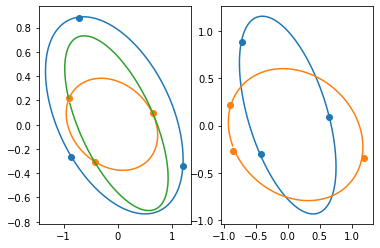

In [16]:
for j in range(2): #iterate over partitions
    plt.subplot(121+j)
    partition = partitions[j]
    for g in partitions[j]: #iterate over detection groups in a partition
        plt.scatter(xys[g,0], xys[g,1])
        for err, (a, e, i, o, O, M0) in of.fit(xys[g,:]): #iterate over orbits that fit detections well
            if err > 0.05: continue

            xs,ys = sample_planets.get_observations(a, e, i, o, O, M0, 2*np.pi*np.sqrt(a**3/mu)*np.arange(0,1,0.01), mu)
            plt.plot(xs[0], ys[0])
    

## Confusion
In the above example, we ended up with two ways of partitioning the detections by planets with estimated orbits that fit the data within 0.05 AU and reasonable eccentricities (<0.3). This is what we consider to be a confusion. Some heuristics that are not currently implemented could help distinguish between partitions. For example, one partition clearly results in orbits that are more co-planar than the other. Other sources of information, e.g. photometry, could also help decide which partition is more likely.